## Import Libraries

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

from prettytable import ALL, PrettyTable

## Read Amazon Products Dataset

In [205]:
filepath = '../input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
col_list = ['name', 'asins', 'reviews.rating', 'reviews.username']
data = pd.read_csv(filepath, usecols=col_list, encoding='utf8')

data.columns = ['product_name', 'product_id', 'rating', 'user']
data

,product_name,product_id,rating,user
0,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",3,Byger yang
1,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",4,ByMG
2,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,BySharon Lambert
3,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,Bymark sexson
4,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,Bylinda
...,...,...,...,...
28327,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,Mom2twinsplus1
28328,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,4,fireman21
28329,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,suzannalicious
28330,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,SandyJ


## Data Statistics & Visualization

### Statistics

In [206]:
print(f"No. of ratings: {data.shape[0]:,}")
print(f"No. of users: {len(np.unique(data['user'])):,}")
print(f"No. of products: {len(np.unique(data['product_id'])):,}")

No. of ratings: 28,332
No. of users: 16,269
No. of products: 65


In [207]:
data.describe()['rating'].T

count    28332.000000
mean         4.514048
std          0.934957
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

### Ratings Count Bar Chart

In [208]:
ratings_count = pd.DataFrame(data['rating'].value_counts()).reset_index()
ratings_count.columns = ['rating', 'count']
ratings_count

,rating,count
0,5,19897
1,4,5648
2,3,1206
3,1,965
4,2,616


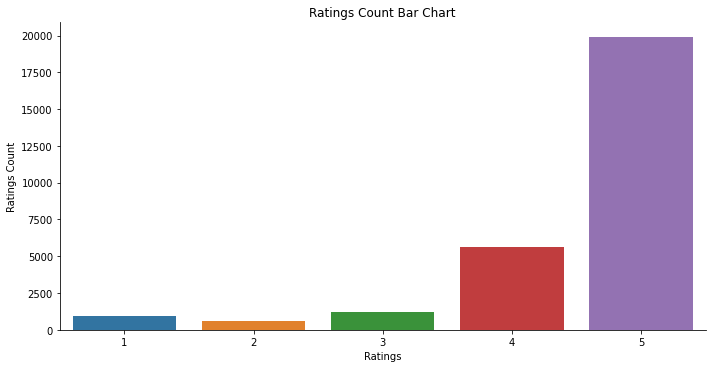

In [209]:
g = sns.catplot(x="rating", data=data, kind="count", aspect=2)
g.set_xlabels("Ratings")
g.set_ylabels("Ratings Count")

plt.title('Ratings Count Bar Chart')

plt.savefig('ratings_count_bar_chart.svg')
plt.show()

### Ratings Count Pie Chart

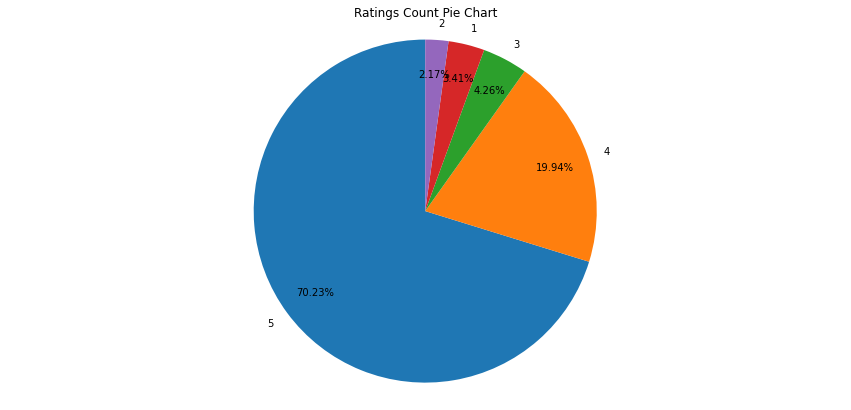

In [210]:
fig, ax = plt.subplots(figsize=(15,7))

ax.pie(ratings_count["count"], labels=ratings_count['rating'], autopct='%1.2f%%', pctdistance=0.8, startangle=90)

ax.axis('equal')
ax.set_title("Ratings Count Pie Chart")

plt.savefig('ratings_count_pie_chart.svg')
plt.show()

## Popularity-Based Recommendation

In [211]:
popular_data = data.groupby("product_id").filter(lambda x:x['rating'].count() >= 500)
popular_products = pd.DataFrame(popular_data.groupby('product_id')['rating'].count())
popular_products = popular_products.sort_values('rating', ascending=False)

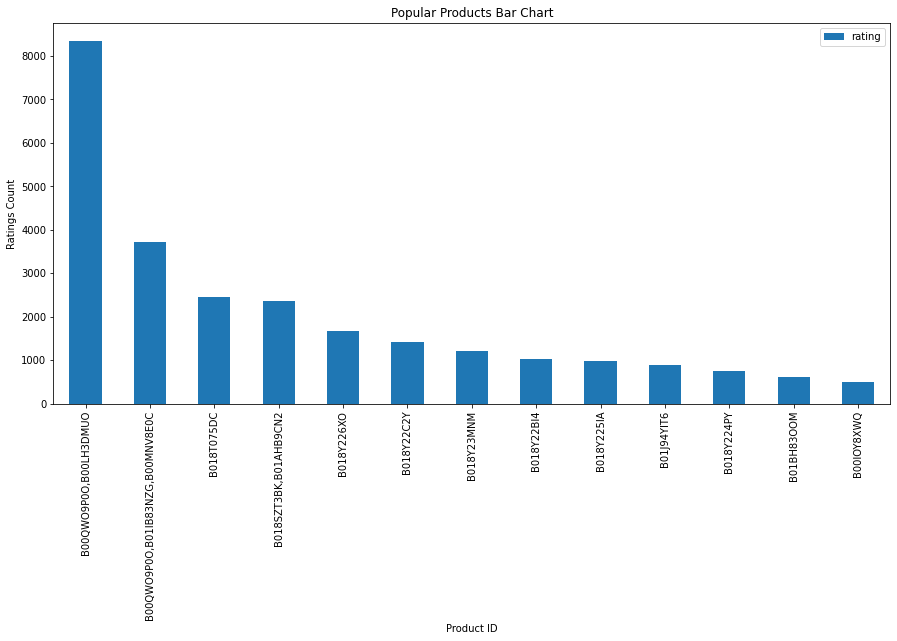

In [212]:
ax = popular_products.head(30).plot(kind = "bar", figsize=(15,7))

ax.set_xlabel("Product ID")
ax.set_ylabel("Ratings Count")
ax.set_title("Popular Products Bar Chart")

plt.savefig('popular_products_bar_chart.svg')

## Collaborative Filtering (Item-Item Recommendation)

In [213]:
cf_data = data[['user', 'product_id', 'rating']]
cf_data.head()

,user,product_id,rating
0,Byger yang,"B00QWO9P0O,B00LH3DMUO",3
1,ByMG,"B00QWO9P0O,B00LH3DMUO",4
2,BySharon Lambert,"B00QWO9P0O,B00LH3DMUO",5
3,Bymark sexson,"B00QWO9P0O,B00LH3DMUO",5
4,Bylinda,"B00QWO9P0O,B00LH3DMUO",5


In [214]:
reader = Reader(rating_scale=(1, 5))

cf_data = Dataset.load_from_df(cf_data, reader)
train_data, test_data = train_test_split(cf_data, test_size=0.3, random_state=10)

In [215]:
knn = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False}, verbose=False)
knn.fit(train_data)

predictions = knn.test(test_data)

In [216]:
# return number of items rated by given user
def get_Iu(uid):
    try:
        return len(train_data.ur[train_data.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
# return number of users that have rated given item
def get_Ui(iid):
    try: 
        return len(train_data.ir[train_data.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [217]:
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4656,Ana778941352,B018Y226XO,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,1156,0.0
2895,Ally,B018Y22C2Y,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,992,0.0
6082,Patti,B018Y226XO,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",4,1156,0.0
2906,Monte,B01ACEKAJY,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,102,0.0
2919,Ubtan,B018Y22C2Y,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",2,992,0.0
2920,Rainning,"B018SZT3BK,B01AHB9CN2",5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,1634,0.0
7650,Jnev,"B018SZT3BK,B01AHB9CN2",5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",3,1634,0.0
2922,DCMack,"B018SZT3BK,B01AHB9CN2",5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,1634,0.0
6094,KenJ,"B018SZT3BK,B01AHB9CN2",5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,1634,0.0
984,Mommyof3,B01J94SBEY,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,155,0.0


In [218]:
worst_predictions = df.sort_values(by='err')[-10:]
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
388,ByJB,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,2625,4.0
5272,ByDee,"B00QWO9P0O,B00LH3DMUO",1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,5867,4.0
1861,ByDaniel,"B00QWO9P0O,B00LH3DMUO",1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",4,5867,4.0
8384,ByCameron,"B00QWO9P0O,B00LH3DMUO",1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",3,5867,4.0
6766,ByJH,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,2625,4.0
3486,ByCris,"B00QWO9P0O,B00LH3DMUO",5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,5867,4.0
2933,ByBecky,"B00QWO9P0O,B00LH3DMUO",5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",2,5867,4.0
6750,ByHeather,"B00QWO9P0O,B00LH3DMUO",1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",7,5867,4.0
5872,ByKeith,"B00QWO9P0O,B00LH3DMUO",5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",3,5867,4.0
5453,ByMW,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",2,2625,4.0


In [219]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8657


0.8656626296553487

## Model-Based Collaborative Filtering System

### Ratings Matrix

In [220]:
product_user_ratings = data.pivot_table(values='rating', index='product_id', columns='user', fill_value=0)
product_user_ratings.head()

user,000G,00Gambler,1000011,10100915,1029cr,1098,118001,1191946,11bee,1215,...,zRoyals,zackeemom,zane1222,zedog83,zeke,zerosky,zetyk,ziggy24,zmax192,ztlbxx
product_id,,,,,,,,,,,,,,,,,,,,,
"B0002LCUZK,B010CEC6MI,B01B25NN64",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B001NIZB5M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B005OOKNP4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B006BGZJJ4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B006GWO7UA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
product_data = data[['product_name', 'product_id']].drop_duplicates(ignore_index=True)
product_data.columns = ['name', 'id']

### Mapping from Product ID to Product Name

In [222]:
product_id_name = product_data.set_index('id')
product_id_name = product_id_name.to_dict(orient='index')

{k: product_id_name[k] for k in list(product_id_name.keys())[:5]}

{'B00QWO9P0O,B00LH3DMUO': {'name': 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)'},
 'B00DIHVMEA,B00EZ1ZTV0': {'name': 'AmazonBasics Nylon CD/DVD Binder (400 Capacity)'},
 'B01E6AO69U,B00L9EPT8O': {'name': 'Amazon Echo ‚Äì White'},
 'B01J24C0TI': {'name': 'Amazon Echo Show - Black'},
 'B073SQYXTW': {'name': 'Echo Spot Pair Kit (Black)'}}

### Mapping from Product Name to Product ID

In [223]:
product_name_id = product_data.set_index('name')
product_name_id = product_name_id.to_dict(orient='index')

{k: product_name_id[k] for k in list(product_name_id.keys())[:5]}

{'AmazonBasics AAA Performance Alkaline Batteries (36 Count)': {'id': 'B00QWO9P0O,B00LH3DMUO'},
 'AmazonBasics Nylon CD/DVD Binder (400 Capacity)': {'id': 'B00DIHVMEA,B00EZ1ZTV0'},
 'Amazon Echo ‚Äì White': {'id': 'B01E6AO69U,B00L9EPT8O'},
 'Amazon Echo Show - Black': {'id': 'B01J24C0TI'},
 'Echo Spot Pair Kit (Black)': {'id': 'B073SQYXTW'}}

### Product IDs according to order of Ratings Matrix

In [224]:
product_ids = list(product_user_ratings.index)
product_ids[:5]

['B0002LCUZK,B010CEC6MI,B01B25NN64',
 'B001NIZB5M',
 'B005OOKNP4',
 'B006BGZJJ4',
 'B006GWO7UA']

### Generate Correlation Matrix using Truncated SVD

In [225]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(product_user_ratings)
correlation_matrix = np.corrcoef(decomposed_matrix)

In [226]:
def show_recommended_products(product_name, product_count=15):
    product_id = product_name_id[product_name]['id']
    i = product_ids.index(product_id)
    coefs = correlation_matrix[i]
    
    recommended_products_info = [{'id': product_user_ratings.index[i], 'coef': coef}
                                 for i, coef in enumerate(coefs) 
                                 if product_user_ratings.index[i] != product_id]
    recommended_products_info.sort(key=lambda x:x['coef'], reverse=True)
    recommended_products_info = recommended_products_info[:product_count]
    results_table = generate_results_table(recommended_products_info)
    
    print(f'Product Name: {product_name}\nProduct ID: {product_id}\n\nRecommended Products:')
    print(results_table)

def generate_results_table(recommended_products_info):
    results_table = PrettyTable()
    results_table.field_names = ['No.', 'Product Name', 'Product ID', 'Correlation Coefficient']
    results_table.hrules = ALL
    
    for i, info in enumerate(recommended_products_info):
        num = i + 1
        product_id = info['id']
        product_name = product_id_name[product_id]['name']
        product_name = (product_name[:100] + '...') if len(product_name) > 100 else product_name
        coef = f"{info['coef']:.4f}"
        
        results_table.add_row([num, product_name, product_id, coef])
    
    return results_table

In [227]:
show_recommended_products('Amazon Echo Show - Black')

Product Name: Amazon Echo Show - Black
Product ID: B01J24C0TI

Recommended Products:
+-----+---------------------------------------------------------------------------------------------------------+----------------------------------+-------------------------+
| No. |                                               Product Name                                              |            Product ID            | Correlation Coefficient |
+-----+---------------------------------------------------------------------------------------------------------+----------------------------------+-------------------------+
|  1  |                              AmazonBasics 16-Gauge Speaker Wire - 100 Feet                              |            B006LW0W5Y            |          0.9984         |
+-----+---------------------------------------------------------------------------------------------------------+----------------------------------+-------------------------+
|  2  |                                 